In [2]:
#tf.__version__

In [3]:
import tensorflow as tf
import time
import numpy as np
import seaborn as sns

import tensorflow.keras.backend as K
#import tensorflow_probability as tfp

from tensorflow.keras.layers import Layer, InputSpec,Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Conv1D,  Dense, Flatten, Reshape

from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans

from datasets import load_mnist, load_usps, load_mrec

In [4]:
# load dataset
Ndataset='mrec'
Nclusters=16
Nsave_dir='temp'
Ngamma=0.1
Ntol=0.001
#num_batches = 100
batch_size = 256
learning_rate = 0.001
nGamma=0.1
NDevice=tf.test.gpu_device_name()
NCPU='/cpu:0'
NGPU=tf.test.gpu_device_name()

In [5]:
xData, YY = load_mrec("mrec20190724fftimg.csv")
#with tf.device(NDevice):
with tf.device('/cpu:0'):
    
    tdataset = tf.data.Dataset.from_tensor_slices((xData))
dataset = tdataset.batch(batch_size).shuffle(buffer_size=100000)

MM (26046, 258)
MREC: (26045, 8, 32, 1)


In [6]:
class Encoder(tf.keras.Model):
    def __init__(self,     input_shape=(8, 32, 1), filters=[32, 64, 128],aclusters=16):
        super(Encoder, self).__init__()
        #self.w='name'
        #self.ishape=input_shape
        self.filters=filters
        #self.pad3
        # model = Sequential()
        if input_shape[0] % 8 == 0:
            pad3 = 'same'
        else:
            pad3 = 'valid'
            
        self.conv0= Conv2D(self.filters[0], 5, strides=(1,2), padding='same', activation='relu', name='conv0', input_shape=input_shape)
        self.conv1= Conv2D(self.filters[1], 5, strides=(2,4), padding='same', activation='relu', name='conv1')
        self.conv2= Conv2D(self.filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv2')
        self.flat= Flatten()
        self.emb=Dense(units=aclusters, name='embedding')
         
               
    def call(self, x, training=True):
        #print('e0',x.shape)
        x = self.conv0(x)
        #print('e1',x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        #print('e3',x.shape)
        x = self.flat(x)
        return self.emb(x)
    
         
   

In [7]:
class Decoder(tf.keras.Model):
     def __init__(self,     output_shape=(8,32,1), filters=[32, 64, 128],aclusters=16):
        super(Decoder, self).__init__()
        if output_shape[0] % 8 == 0:
            pad3 = 'same'
        else:
            pad3 = 'valid'
        #self.ishape=input_shape
        self.filters=filters
      
        self.dense1=Dense(units=self.filters[2]*int(output_shape[0]/2)*int(output_shape[0]/8),input_shape=(aclusters,), activation='relu')

        self.resh1=Reshape((int(output_shape[0]/4), int(output_shape[1]/16), filters[2]))
        self.deconv2=Conv2DTranspose(self.filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv2')

        self.deconv1=Conv2DTranspose(self.filters[0], 3, strides=(2,4), padding='same', activation='relu', name='deconv1')
        self.deconv0=Conv2DTranspose(output_shape[2], 5, strides=(1,2), padding='same', name='deconv0')
    
     def call(self, x, training=True):
        #print('d0',x.shape)
        x = self.dense1(x)
        #print('d1',x.shape)
         
        x = self.resh1(x)
     
        x = self.deconv2(x)
        x = self.deconv1(x)
        x = self.deconv0(x)       
        return x 

In [8]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters,n_dim, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.n_dim=n_dim
        self.alpha = alpha
        self.initial_weights = weights
        #self.input_spec = InputSpec(ndim=2)
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, n_dim))
        self.clusters = self.add_weight('clusters',(self.n_clusters, self.n_dim),trainable=True, initializer='glorot_uniform')
 
      
        print('initLC')

 

    def build(self, input_shape):
        print('buildlc', input_shape)
        assert len(input_shape) == 2
        print('addw:',self.n_clusters)
        #self.clusters = self.add_weight('clusters',(self.n_clusters, self.n_dim),trainable=True, initializer='glorot_uniform')
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        super(ClusteringLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
class ClusteringModel(tf.keras.Model):
   
    def __init__(self,     aClusters=16,aDim=16):
        super(ClusteringModel, self).__init__()
        #self.w='name'
        self.emb=ClusteringLayer(n_clusters=aClusters,n_dim=aDim, name='clustering')
         
               
    def call(self, x, training=True):
        
        return self.emb(x)
    
    def setWeights(self,aWeights):
        self.emb.set_weights(aWeights)
 

In [10]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
#checkpoint = tf.train.Checkpoint(myModel=model,optimizer=optimizer)
g_encoder = Encoder(aclusters=Nclusters)
g_decoder = Decoder(aclusters=Nclusters)
         

In [11]:
def loss_mse( inputs, targets):
    #error = inputs - targets
    #sq=tf.square(error)
    sq=tf.keras.losses.MSE(inputs,targets)

    #return tf.compute_average_loss(   sq,        global_batch_size=GLOBAL_BATCH_SIZE)
    return tf.reduce_mean(sq)
def loss_kld(inputs,pred):
    _nn=tf.keras.losses.KLD( inputs,pred)
    return tf.reduce_mean(_nn)

In [12]:
def pre_train():
    #start = time.time()
    loss = 0
    xoptimizer = tf.optimizers.Adam()
    
    for (batch, (x)) in enumerate(dataset.take(-1)):
        #if batch % 10 == 0:
        #print('mse',x.shape)
                 
        #     print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        loss = 0
        with tf.device(NGPU):    
            with tf.GradientTape() as tape:
                g_encoder.trainable = True
                g_decoder.trainable = True
                z = g_encoder(x, training=True)
                x_hat = g_decoder(z, training=True)
                loss = loss_mse(x, x_hat)
            #print('mse',x.shape, loss.numpy())
                  
        #for  v in variables:
        #    print ("batch: ", v.name,'  ',v.shape)
        #print('nam:',g_encoder.trainable_variables.shape)
        #print('var:',variables)
                variables = g_encoder.trainable_variables + g_decoder.trainable_variables
                gradients = tape.gradient(loss, variables)
        
                xoptimizer.apply_gradients(zip(gradients, variables))
        #xoptimizer.minimize(loss,variables)
    return loss

In [13]:
EPOCHS = 8

for epoch in range(EPOCHS):
    start = time.time()
    ls=pre_train()
    end = time.time()
    xdiff= end - start
    print('Epoch {}  Loss {:.4f} time:{:.3f} s'.format(epoch + 1,ls.numpy(),xdiff))
    nn=g_encoder.predict(xData)
    nnp=nn.argmax(1)
    
    #printMetrics('pre: ',nnp,ls)
  

Epoch 1  Loss 0.0064 time:3.244 s
Epoch 2  Loss 0.0065 time:1.801 s
Epoch 3  Loss 0.0064 time:1.804 s
Epoch 4  Loss 0.0061 time:1.821 s
Epoch 5  Loss 0.0062 time:1.805 s
Epoch 6  Loss 0.0060 time:1.827 s
Epoch 7  Loss 0.0060 time:1.810 s
Epoch 8  Loss 0.0059 time:1.826 s


In [14]:
print('Initializing cluster centers with k-means.')
kmeans = KMeans(n_clusters=Nclusters, n_init=20)
start = time.time()
with tf.device(tf.test.gpu_device_name()):  
#with tf.device("/cpu:0"):  

    y_pr = kmeans.fit_predict(g_encoder.predict(xData))
end = time.time()
  
xdiff= end - start
print('Epoch {}  Loss {:.4f} time:{:.3f} s'.format(epoch + 1,ls.numpy(),xdiff))
      
print('data {} time {:.3f}s'.format,xData.shape,xdiff)
print('pred:',y_pr.shape)
print(kmeans.cluster_centers_.shape)

Initializing cluster centers with k-means.
Epoch 8  Loss 0.0059 time:3.309 s
<built-in method format of str object at 0x7f2e90091150> (26045, 8, 32, 1) 3.30891489982605
pred: (26045,)
(16, 16)


In [15]:
g_clustering=ClusteringModel(Nclusters,Nclusters)
g_clustering.setWeights([kmeans.cluster_centers_])

initLC


In [16]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


In [17]:
def cluster_train():
    nn2=g_encoder.predict(xData)
    nn=g_clustering.predict(nn2)
    #nnp=nn.argmax(1)
    
    p = target_distribution(nn)  # update the auxiliary target distribution p
    with tf.device(NCPU):
        ndataset = tf.data.Dataset.from_tensor_slices((xData, p)).batch(batch_size).shuffle(buffer_size=100000)
    #printMetrics('Iter ',nnp,0.1)
    #print('x',xData[0])
    #print('q',nn[0])
    #print('p',p.shape, p[0])
    loss = 0
    variables = g_encoder.variables + g_decoder.variables+ g_clustering.variables
    #variables = g_encoder.variables + g_decoder.variables+ CLmodel.variables
         
    for (batch, (x, labels)) in enumerate(ndataset.take(-1)):
        #if batch % 10 == 0:
        #    nn=g_encoder.predict(xData)
    
            #p = target_distribution(nn)  # update the auxiliary target distribution p
            #yn=CLmodel(nn)
            #_nn=tf.keras.losses.KLD( p,yn)
            #print('nn',_nn)
        #     print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        
        #q, _ = self.model.predict(x, verbose=0)
        #p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
        #        self.y_pred = q.argmax(1)
   
        with tf.device(NGPU):    
          with tf.GradientTape() as tape:
            g_encoder.trainable = True
            g_decoder.trainable = True
            g_clustering.trainable =True
            z = g_encoder(x, training=True)
            #y_pred = tf.argmax(z,1)
            x_hat = g_decoder(z, training=True)
            #y_hat=CLmodel(z)
            y_hat=g_clustering(z,training=True)
            #print('yhat',y_hat.numpy(),y_pred.shape, labels.shape)
            #id=batch * batch_size
            #pll=p[id:(id + batch_size)]
            lossmse = loss_mse(x, x_hat)
            losskld = loss_kld(labels,y_hat)   
            loss=lossmse+losskld*0.2
        
        if batch % 14 == 0:
            print('lossmse',lossmse.numpy(),':kld',losskld.numpy())
            #print('labe=',labels[0])
            #print('yhat',y_hat[0])
            #print('pll=',pll[0])
            #print('kld=',tf.keras.losses.KLD( pll[0],y_hat[0]))
            
                #print(labels)
      
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
    
    return loss
 

In [18]:
EPOCHS = 8

for epoch in range(EPOCHS):
    start = time.time()
    ls=cluster_train()
    end = time.time()
    xdiff= end - start
    print('Epoch {}  Loss {:.4f}  time:{} sec'.format(epoch + 1,ls.numpy(),xdiff))
             


buildlc (None, 16)
addw: 16


W0728 19:41:44.528968 139840294803264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


lossmse 0.0034207576 :kld 0.052232742
lossmse 0.003765401 :kld 0.062927775
lossmse 0.00614064 :kld 0.11474947
lossmse 0.005357423 :kld 0.12571695
lossmse 0.0046794624 :kld 0.057894863
lossmse 0.0030560517 :kld 0.04392152
lossmse 0.006847238 :kld 0.12706207
lossmse 0.0034744772 :kld 0.036079172
Epoch 1  Loss 0.0101  time:5.21419095993042 sec
lossmse 0.0059359176 :kld 0.13420793
lossmse 0.00514281 :kld 0.056746647
lossmse 0.0027332755 :kld 0.049040213
lossmse 0.0041104327 :kld 0.04973236
lossmse 0.0033071102 :kld 0.043434065
lossmse 0.004117199 :kld 0.045212805
lossmse 0.006161908 :kld 0.108065195
lossmse 0.0031471387 :kld 0.039646037
Epoch 2  Loss 0.0129  time:4.545493841171265 sec
lossmse 0.005646078 :kld 0.1263506
lossmse 0.0037368496 :kld 0.06816332
lossmse 0.0028980444 :kld 0.047615655
lossmse 0.0028999592 :kld 0.047989193
lossmse 0.0027429345 :kld 0.043094043
lossmse 0.0037682177 :kld 0.054457255
lossmse 0.006429513 :kld 0.17559934
lossmse 0.007156767 :kld 0.2132439
Epoch 3  Loss 0

In [19]:
zzt = g_encoder.predict(xData)
yyt=g_clustering.predict(zzt)

yyn=yyt.argmax(1)
print(yyn)
print(xData[1].reshape(8,32))

[10 10 14 ... 11  7  7]
[[0.4791655  0.6506191  0.66533524 0.6720642  0.69119924 0.70377326
  0.75736564 0.6955516  0.63635725 0.720455   0.6463831  0.7202592
  0.7367619  0.7974321  0.7227733  0.70757157 0.75367093 0.5826038
  0.62074804 0.63052475 0.6647367  0.6124149  0.6693753  0.5649615
  0.64578736 0.7008564  0.66768014 0.5572128  0.6735926  0.5859675
  0.63357705 0.66040117]
 [0.92967695 0.7412658  0.6430992  0.6374515  0.6567088  0.70857966
  0.7107904  0.72853214 0.6602382  0.73200107 0.5281317  0.59558177
  0.59111345 0.8080831  0.7016718  0.6626541  0.74116737 0.5892058
  0.5650489  0.6265568  0.62064177 0.57758105 0.62121576 0.6866966
  0.6520051  0.6787063  0.77107555 0.70412236 0.34894556 0.68173856
  0.6441513  0.63528043]
 [0.4959941  0.6425448  0.68709135 0.5965316  0.65354854 0.6624599
  0.7424743  0.7343648  0.54636514 0.6437499  0.44544017 0.71893734
  0.61141455 0.80243313 0.5075138  0.63820225 0.6538028  0.65876544
  0.66658825 0.6364938  0.4755486  0.5940716  0.5

Examples:


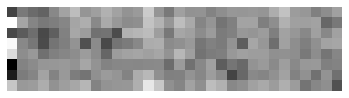

Class: 10 - Model's Output Class:


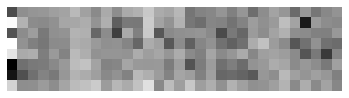

Class: 10 - Model's Output Class:


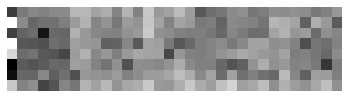

Class: 14 - Model's Output Class:


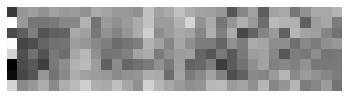

Class: 10 - Model's Output Class:


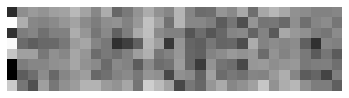

Class: 10 - Model's Output Class:


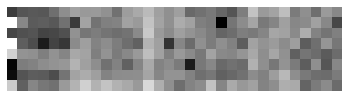

Class: 10 - Model's Output Class:


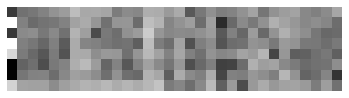

Class: 10 - Model's Output Class:


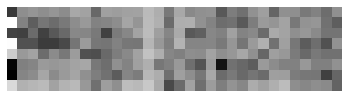

Class: 10 - Model's Output Class:


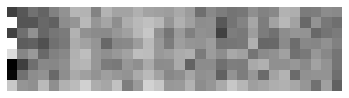

Class: 14 - Model's Output Class:


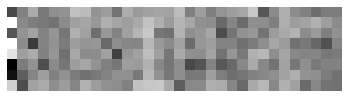

Class: 10 - Model's Output Class:


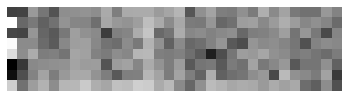

Class: 10 - Model's Output Class:


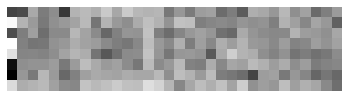

Class: 14 - Model's Output Class:


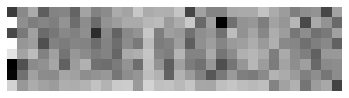

Class: 14 - Model's Output Class:


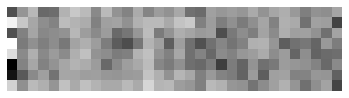

Class: 10 - Model's Output Class:


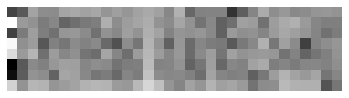

Class: 10 - Model's Output Class:


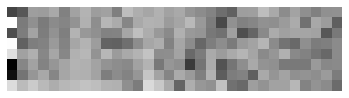

Class: 14 - Model's Output Class:


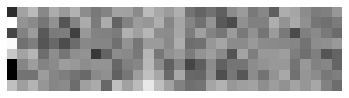

Class: 10 - Model's Output Class:


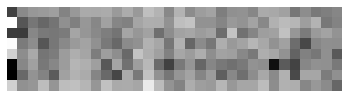

Class: 14 - Model's Output Class:


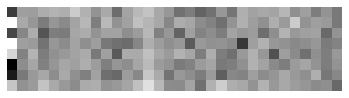

Class: 14 - Model's Output Class:


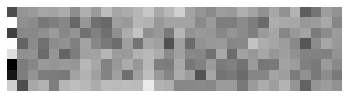

Class: 14 - Model's Output Class:


In [20]:
import matplotlib.pyplot as plt
#print('Loss:', loss)
print('Examples:')
for i in range(20):
    plt.imshow(xData[i].reshape(8,32), cmap='gray')
    plt.axis('off')
    plt.show()
    print('Class:', yyn[i], '- Model\'s Output Class:')

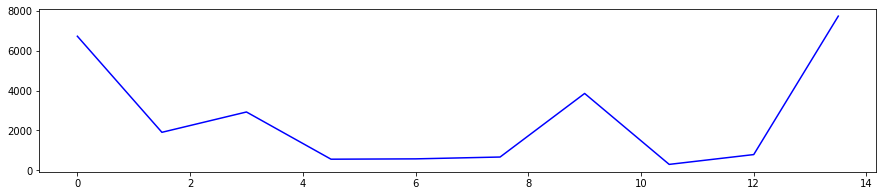

In [21]:
plt.figure(figsize=(15,3))

#fig, ax1 = plt.subplots()
values, base = np.histogram(yyn)
plt.plot(base[:-1], values, c='blue')

#ax2 = ax1.twinx()
#ax1.plot(test)

#plt.plot(yyn,color="red")
plt.show()

(26045, 2)


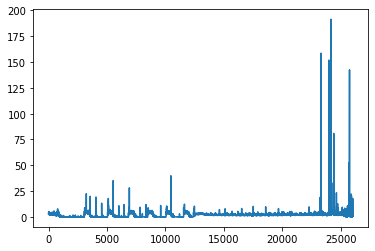

In [22]:
print(YY.shape)
plt.plot(YY.iloc[:,1])
plt.show()

In [23]:
yyno=yyn.reshape(-1,1)
print('yyn',yyno.shape)
print('YY',YY.shape)

yyn (26045, 1)
YY (26045, 2)


In [24]:
YYO=np.concatenate((YY, yyno), axis=1)
print(YYO.shape)

(26045, 3)


In [25]:
np.savetxt("mrec.csv", YYO, delimiter=",")

In [26]:
yyt.shape


(26045, 16)

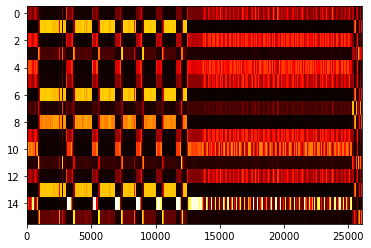

In [27]:
plt.imshow(yyt.transpose(), cmap='hot', interpolation='nearest',aspect='auto')
#ax = sns.heatmap(yyt, linewidth=0.5)
plt.show()